In [28]:
import numpy as np
import matplotlib.pyplot as plt

def clouds(num_points=100):
    centers = [(1, 1), (-1, -1)]
    spreads = [0.5, 0.7]
    labels = [-1, 1]
    
    X = []
    y = []
    for center, spread, label in zip(centers, spreads, labels):
        X += np.random.multivariate_normal(center, spread * np.identity(2), num_points).tolist()
        y += [label] * num_points
    
    return X, y

In [29]:
X, y = clouds(100)

#### Implementing Feature map

ZZFeatureMap is one of the angle encoding feature maps because it uses ZZ-rotations on 2 qubits

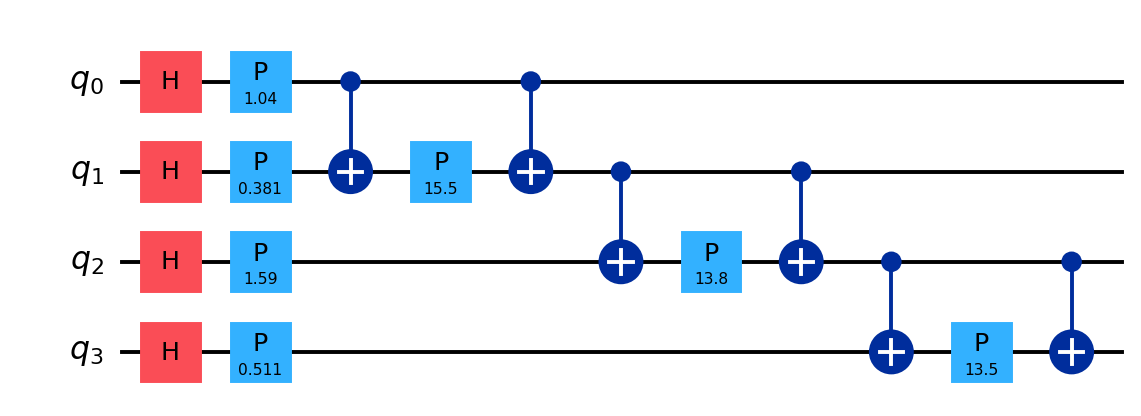

In [30]:
import numpy as np
from qiskit.circuit.library import ZZFeatureMap

num_qubits = 4
x = np.random.random(num_qubits)

data = ZZFeatureMap(feature_dimension=num_qubits, reps=1, entanglement="linear")
data.assign_parameters(x, inplace=True)
data.decompose().draw("mpl", style="iqx", scale=1.4)

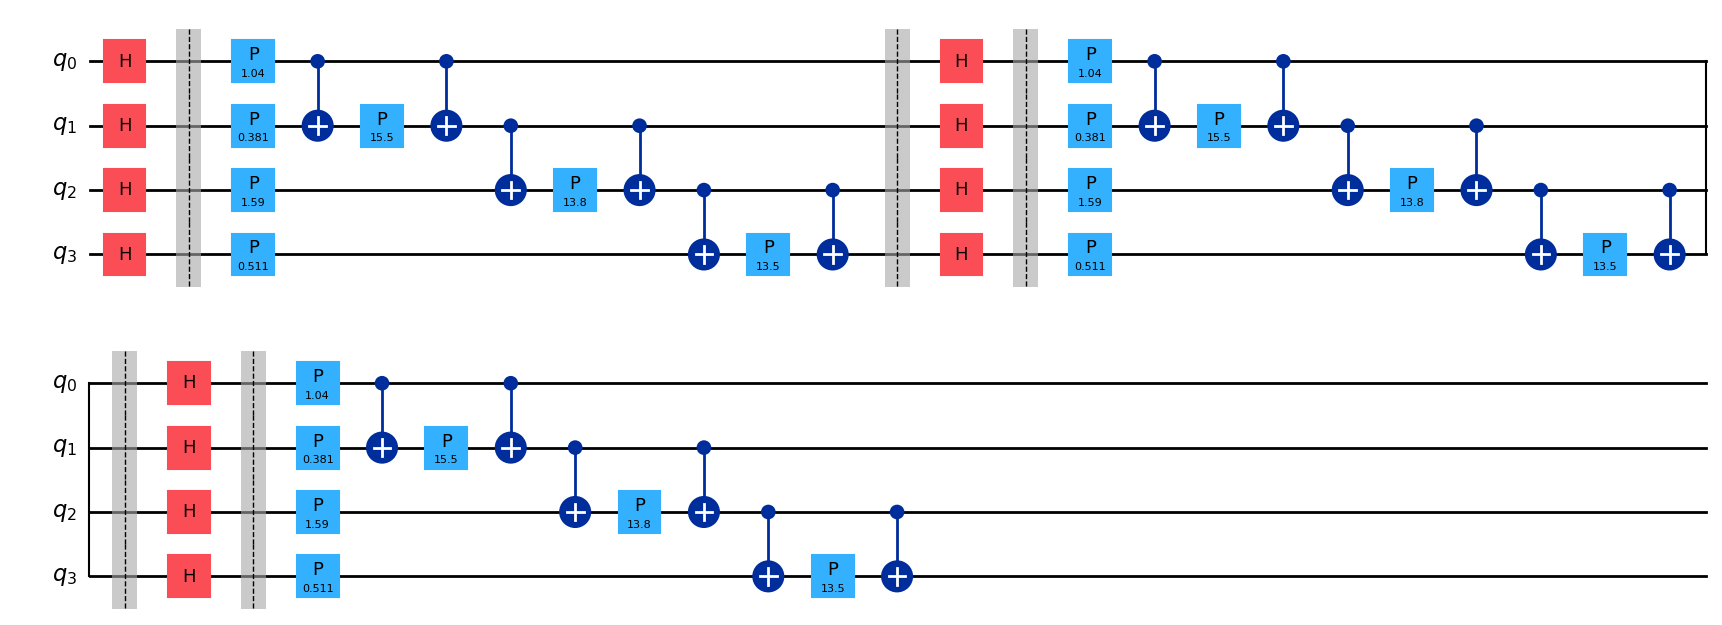

In [31]:
data = ZZFeatureMap(feature_dimension=num_qubits, reps=3, entanglement="linear", insert_barriers=True)
data.assign_parameters(x, inplace=True)
data.decompose().draw("mpl", style="iqx")

#### Building a quantum kernel

In [32]:
from qiskit import transpile, BasicAer, QuantumCircuit

backend = BasicAer.get_backend("qasm_simulator")
shots = 1024

dimension = 2
feature_map = ZZFeatureMap(dimension, reps=1)

def evaluate_kernel(x_i, x_j):
    circuit = QuantumCircuit(dimension)
    circuit.compose(feature_map.assign_parameters(x_i), inplace=True)
    circuit.compose(feature_map.assign_parameters(x_j).inverse(), inplace=True)
    circuit.measure_all()
    
    transpiled = transpile(circuit, backend)
    counts = backend.run(transpiled, shots=shots).result().get_counts()
    
    return counts.get("0" * dimension, 0) / shots #counts how many times we measure zero

In [33]:
evaluate_kernel(X[2], X[3])

0.193359375

Or use qiskit directly!

In [34]:
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
kernel.evaluate(X[2], X[3])

array([[0.18880069]])

#### Classification

In [35]:
def circle():
    num_points = 250
    points = 1 - 2 * np.random.random((num_points, 2))
    
    radius = 0.6
    labels = [1 if np.linalg.norm(point) > radius else -1 for point in points]
    
    return points, labels

Text(0, 0.5, '$x_2$')

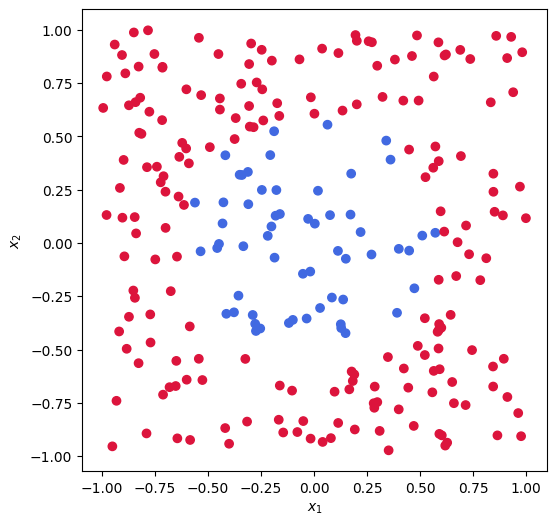

In [36]:
points, labels = circle()
colors = ["crimson" if label == 1 else "royalblue" for label in labels]

plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1], color=colors)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

entering quantum feature map in the classical algo

In [37]:
from sklearn.svm import SVC

qsvm = SVC(kernel=kernel.evaluate)
qsvm.fit(points, labels)
predicted = qsvm.predict(points)

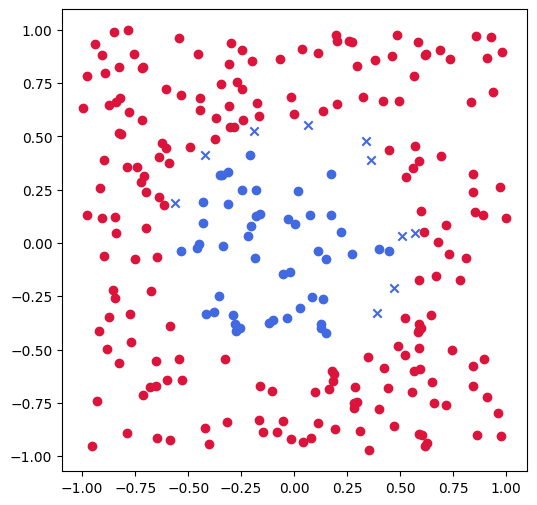

In [38]:
markers = ["o" if label == predicted_label else "x" for label, predicted_label in zip(labels, predicted)]
plt.figure(figsize=(6, 6))
for point, marker, color in zip(points.tolist(), markers, colors):
    plt.scatter(point[0], point[1], color=color, marker=marker)